In [1]:
import ophion
import json
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas
import numpy as np
import itertools

In [2]:
%matplotlib inline

In [3]:
O = ophion.Ophion("http://bmeg.compbio.ohsu.edu")

In [4]:
#get all CCLE samples
all_samples = O.query().has("gid", "cohort:CCLE").outgoing("hasSample").values(["gid"]).execute()

In [5]:
GENES = ["CDKN2A", "PTEN", "TP53", "SMAD4"]
#GENES = ["CDKN2A", "PTEN", "TP53", "SMAD4", "CNGB1", "CYP2A6", "LMOD1", "RBPJL", "PARP4"]

In [6]:
mut_samples = {}
norm_samples = {}
for g in GENES:
    #get CCLE samples with mutation
    res = O.query().has("gid", "gene:%s" % (g)).incoming("variantInGene").outgoing("variantInBiosample").mark("a")\
    .incoming("hasSample").has("gid", "cohort:CCLE").select("a").values(["gid"]).execute()
    
    if len(res) > 10:
        mut_samples[g] = list(set(res))

        #get CCLE samples without mutation
        norm_samples[g] = list(set(all_samples).difference(mut_samples[g]))

        print "%s Positive Set: %d" % (g, len(mut_samples[g]))
        print "%s Negative Set: %d" % (g, len(norm_samples[g]))

CDKN2A Positive Set: 48
CDKN2A Negative Set: 998
PTEN Positive Set: 142
PTEN Negative Set: 904
TP53 Positive Set: 553
TP53 Negative Set: 493
SMAD4 Positive Set: 62
SMAD4 Negative Set: 984


In [7]:
#get response values for the positive set (samples with mutation)
#and collect AUC value by drug
pos_response = {}
for g in GENES:
    pos_response[g] = {}
    for row in O.query().has("gid", O.within(mut_samples[g])).outEdge("responseToCompound").mark("a").inVertex().mark("b").select(["a", "b"]).execute():
        for v in json.loads(row['a']['properties']['responseSummary']):
            if v['type'] == "AUC":
                compound = row['b']['gid']
                if compound not in pos_response[g]:
                    pos_response[g][compound] = [ v["value"] ]
                else:
                    pos_response[g][compound].append(v["value"])

In [8]:
#get response values for the negative set (samples without mutation)
#and collect AUC value by drug
neg_response = {}
for g in GENES:
    neg_response[g] = {}

    for row in O.query().has("gid", O.within(norm_samples[g])).outEdge("responseToCompound").mark("a").inVertex().mark("b").select(["a", "b"]).execute():
        for v in json.loads(row['a']['properties']['responseSummary']):
            if v['type'] == "AUC":
                compound = row['b']['gid']
                if compound not in neg_response[g]:
                    neg_response[g][compound] = [ v["value"] ]
                else:
                    neg_response[g][compound].append(v["value"])

In [9]:
print len(pos_response)
print len(neg_response)
print pos_response.keys()

4
4
['SMAD4', 'PTEN', 'CDKN2A', 'TP53']


In [10]:
#Collect t-test statistics
drugs = set(itertools.chain.from_iterable( i.keys() for i in pos_response.values() ))
out = []
for drug in drugs:
    for g in GENES:
        row = {"drug" : drug, "mutation" : g}
        mut_values = pos_response[g][drug]
        norm_values = neg_response[g][drug]
        if len(mut_values) > 5 and len(norm_values) > 5:
            s = stats.ttest_ind(mut_values, norm_values, equal_var=False)
            row["t-statistic"] = s.statistic
            row["t-pvalue"] = s.pvalue
            s = stats.f_oneway(mut_values, norm_values)
            row["a-statistic"] = s.statistic
            row["a-pvalue"] = s.pvalue
            out.append(row)

In [15]:
#print data sorted by statistical value
df = pandas.DataFrame(out, columns=["drug", "mutation", "t-statistic", "t-pvalue", "a-statistic", "a-pvalue"]).sort_values("a-pvalue")

13.534497907 0.960924747106
12.4568282282 1.70322764773


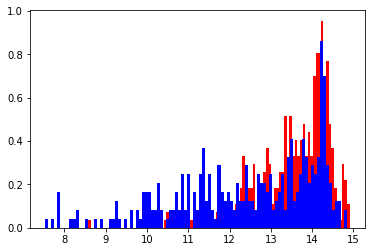

In [12]:
drug = "compound:nutlin-3"
gene = "TP53"
_ = plt.hist(pos_response[gene][drug], bins=100, normed=True, color="R")
_ = plt.hist(neg_response[gene][drug], bins=100, normed=True, color="B")
print np.mean(pos_response[gene][drug]), np.std(pos_response[gene][drug])
print np.mean(neg_response[gene][drug]), np.std(neg_response[gene][drug])

In [13]:
stats.f_oneway(pos_response[gene][drug], neg_response[gene][drug])

F_onewayResult(statistic=121.68103667046283, pvalue=2.3791567976155418e-26)

In [16]:
df.to_csv("drug_select.list", sep="\t")